#### Importing required libraries

In [44]:
import json
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, Subset, SubsetRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torchtext.vocab import GloVe

In [45]:
with open('NER_TRAIN_JUDGEMENT.json') as file:
    data = json.load(file)

In [46]:
with open('NER_TEST_JUDGEMENT.json') as file:
    test_data = json.load(file)

In [47]:
train, val = train_test_split(data, test_size=0.15, random_state=42)

#### BIO Encoding of data

In [48]:
unique_labels = set()
for i in range(len(data)):
    for annotation in data[i]['annotations'][0]['result']:
        label = annotation['value']['labels'][0]
        unique_labels.add(label)
print(unique_labels)

{'PROVISION', 'STATUTE', 'GPE', 'OTHER_PERSON', 'ORG', 'CASE_NUMBER', 'RESPONDENT', 'COURT', 'DATE', 'PRECEDENT', 'WITNESS', 'PETITIONER', 'JUDGE'}


#### Cleaning Data - Replacing escape sequences with spaces

In [49]:
def clean_text(text):
    special_chars = ['\x05', '\t', '\n', '\x0c', '\x11', '\x12', '\x13', '\x14', '\x16', '\x1a', '\x80', '\x9d', '\xa0', '\xad', '\uf076']
    for char in special_chars:
        text = text.replace(char, ' ')
    return text

#### Storing all the label boundaries in a list

In [50]:
def border_index(annotations):
    border_indices = []
    for annotation in annotations[0]['result']:
        start = annotation['value']['start']
        end = annotation['value']['end']
        label = annotation['value']['labels'][0]
        label = label.upper()
        border_indices.append([start, end, label])
    border_indices.sort(key=lambda x: x[0])
    return border_indices

#### Adding spaces on the boundaries of labels where there is no space

In [51]:
def border_spacing(text, border_indices):
    i = 0
    while i < len(text):
        for border in border_indices:
            if (i==border[0] or i==border[1]):
                index = border_indices.index(border)
                if (i==border[0] and i!=0 and text[i-1]!=' '):
                    text = text[:i] + ' ' + text[i:]
                    for j in range(index, len(border_indices)):
                        if border_indices[j][0] >= i:
                            border_indices[j][0] += 1
                        if border_indices[j][1] >= i:
                            border_indices[j][1] += 1
                if (i==border[1] and i!=len(text)-1 and text[i]!=' '):
                    text = text[:i] + ' ' + text[i:]
                    for j in range(index, len(border_indices)):
                        if border_indices[j][0] >= i:
                            border_indices[j][0] += 1
                        if border_indices[j][1] >= i:
                            border_indices[j][1] += 1
                i += 1
        i += 1
    return text, border_indices

#### Performing Tokenization by space and BIO Encoding

In [52]:
def bio_encoding(text, border_indices):
    tokens = text.split()
    labels = ['O'] * len(tokens)
    for annotation in border_indices:
        start = annotation[0]
        end = annotation[1]
        label = annotation[2]
        label = label.upper()
        label_start_token = None
        label_end_token = None
        curr_token_index = 0
        i = 0
        while (i < len(text)):
            if (text[i] == ' '):
                i += 1
            else:
                curr_word = ''
                if (i == start):
                    label_start_token = curr_token_index
                    while (i < end):
                        current_word = ''
                        if (text[i] == ' '):
                            while (text[i] == ' '):
                                i += 1
                        else: 
                            while (i < len(text) and text[i] != ' '):
                                current_word += text[i]
                                i += 1
                            if (tokens[curr_token_index] == current_word):
                                curr_token_index += 1
                    label_end_token = curr_token_index
                else: 
                    while (i < len(text) and text[i] != ' '):
                        curr_word += text[i]
                        i += 1
                    if (tokens[curr_token_index] == curr_word):
                        curr_token_index += 1
        if (label_end_token == None):
            label_end_token = len(tokens) - 1
        if (label_start_token == None):
            continue
        for i in range(label_start_token, label_end_token):
            if i == label_start_token:
                labels[i] = 'B_' + label
            else:
                labels[i] = 'I_' + label
    return labels

#### BIO Encoding of data

In [53]:
def convert_to_bio(data):
    processed_data = {}
    for i in range(len(data)):
        id = data[i]['id']
        annotations = data[i]['annotations']
        text = data[i]['data']['text']
        text = clean_text(text)
        border_indices = border_index(annotations)
        text, border_indices = border_spacing(text, border_indices)
        labels = bio_encoding(text, border_indices)
        processed_data[id] = {'text': text, 'labels': labels}
    return processed_data

#### Saving the data

In [54]:
processed_train = convert_to_bio(train)
processed_val = convert_to_bio(val)
processed_test = convert_to_bio(test_data)

In [55]:
# dumping the processed data
with open('NER_TRAIN_JUDGEMENT_PROCESSED.json', 'w') as file:
    json.dump(processed_train, file, indent=4)
with open('NER_VAL_JUDGEMENT_PROCESSED.json', 'w') as file:
    json.dump(processed_val, file, indent=4)
with open('NER_TEST_JUDGEMENT_PROCESSED.json', 'w') as file:
    json.dump(processed_test, file, indent=4)

#### Loading data

In [56]:
with open('NER_TRAIN_JUDGEMENT_PROCESSED.json') as file:
    train_data = json.load(file)
with open('NER_VAL_JUDGEMENT_PROCESSED.json') as file:
    val_data = json.load(file)
with open('NER_TEST_JUDGEMENT_PROCESSED.json') as file:
    test_data = json.load(file)

#### Preparing the data

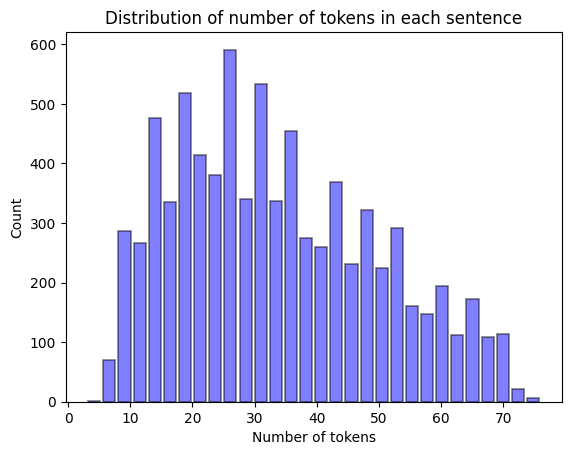

In [57]:
# plotting data distribution of number of tokens in each sentence
import matplotlib.pyplot as plt
label_counts = []
for key in train_data.keys():
    label_counts.append(len(train_data[key]['labels']))
plt.hist(label_counts, bins=30, alpha=0.5, color='b', edgecolor='black', linewidth=1.2, histtype='bar', align='mid', orientation='vertical', rwidth=0.8, label='Number of tokens')
plt.title('Distribution of number of tokens in each sentence')
plt.xlabel('Number of tokens')
plt.ylabel('Count')
plt.show()

In [58]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [59]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 8019
Validation data size: 1416
Test data size: 949


In [60]:
for i in range(5):
    text, labels = train[i][0], train[i][1]
    print(f"Text: {text}\nLabels: {labels}\n")

Text: Therefore, while interpreting statutory provisions, the courts should keep in mind the objectives or purpose for which statute has been enacted.
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: The petitioner in W.P.No.15821 of 2008 was never considered for appointment under the National Rural Employment Guarantee Scheme either through Employment Exchange sponsorship or by Outsourcing Agencies.
Labels: ['O', 'O', 'O', 'B_CASE_NUMBER', 'I_CASE_NUMBER', 'I_CASE_NUMBER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: The factum of accident, allegation of rash and negligent driving causing death of Sukendra Pal Singh were denied.
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_OTHER_PERSON', 'I_OTHER_PERSON', 'I_OTHER_PERSON', 'O', 'O']

Text: ..36..    W.A.No.655/2012 & others Meaning thereby that ex

In [61]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 37866
Words and their counts: [('Therefore,', 97), ('while', 164), ('interpreting', 6), ('statutory', 76), ('provisions,', 10)]


In [62]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 37868


In [63]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

Word-to-index: [('Therefore,', 0), ('while', 1), ('interpreting', 2), ('statutory', 3), ('provisions,', 4)]
Index-to-word: [(0, 'Therefore,'), (1, 'while'), (2, 'interpreting'), (3, 'statutory'), (4, 'provisions,')]


In [64]:
# finding all the unique labels in the dataset
label_count = {}
for i in range(len(data)):
    labels = data[i][1]
    for label in labels:
        if label not in label_count:
            label_count[label] = 1
        else:
            label_count[label] += 1
print(f"Number of unique labels in the dataset: {len(label_count)}")
print(f"Labels and their counts: {list(label_count.items())}")
print(f"Labels and their counts: {list(label_count.items())}")
label_to_idx = {label:idx for idx, label in enumerate(label_count.keys())}
idx_to_label = {idx:label for label, idx in label_to_idx.items()}
print(f"Label-to-index: {list(label_to_idx.items())}")
print(f"Index-to-label: {list(idx_to_label.items())}")

Number of unique labels in the dataset: 27
Labels and their counts: [('O', 294339), ('B_CASE_NUMBER', 1161), ('I_CASE_NUMBER', 3975), ('B_ORG', 1600), ('I_ORG', 2945), ('B_OTHER_PERSON', 2929), ('I_OTHER_PERSON', 2252), ('B_STATUTE', 2026), ('I_STATUTE', 3659), ('B_PROVISION', 2642), ('I_PROVISION', 4326), ('B_COURT', 1471), ('I_COURT', 2854), ('B_WITNESS', 939), ('B_PRECEDENT', 1528), ('I_PRECEDENT', 13435), ('B_DATE', 2106), ('B_PETITIONER', 473), ('I_PETITIONER', 384), ('I_WITNESS', 810), ('B_GPE', 1581), ('B_RESPONDENT', 329), ('I_RESPONDENT', 448), ('I_DATE', 1480), ('B_JUDGE', 575), ('I_JUDGE', 398), ('I_GPE', 327)]
Labels and their counts: [('O', 294339), ('B_CASE_NUMBER', 1161), ('I_CASE_NUMBER', 3975), ('B_ORG', 1600), ('I_ORG', 2945), ('B_OTHER_PERSON', 2929), ('I_OTHER_PERSON', 2252), ('B_STATUTE', 2026), ('I_STATUTE', 3659), ('B_PROVISION', 2642), ('I_PROVISION', 4326), ('B_COURT', 1471), ('I_COURT', 2854), ('B_WITNESS', 939), ('B_PRECEDENT', 1528), ('I_PRECEDENT', 13435), 

In [23]:
from torchtext.vocab import GloVe
glove_vectors = GloVe(name='6B', dim=300)
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = glove_vectors[word]
    else:
        word_embeddings[idx] = glove_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

.vector_cache/glove.6B.zip:   2%|▏         | 18.2M/862M [00:03<03:03, 4.60MB/s]   

KeyboardInterrupt



In [79]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (37868, 300)


#### Setting up DataLoaders

In [80]:
def collate_fn(batch):
    """
        Padding the sequences to the maximum length sequence in the batch
        Args:
            batch: list of individual elements of the dataset
        Returns:
            {'text' : padded_texts, 'labels' : padded_labels}
    """
    texts, labels = [item['text'] for item in batch], [item['labels'] for item in batch]
    max_len = max([len(text) for text in texts])
    padded_texts, padded_labels = [], []
    for i in range(len(texts)):
        text, label = texts[i], labels[i]
        # padding text and label sequences
        text = text + [word_to_index['PAD']] * (max_len - len(text))
        label = label + [label_to_idx['O']] * (max_len - len(label))
        padded_texts.append(text)
        padded_labels.append(label)
    return {'text': torch.tensor(padded_texts), 'labels': torch.tensor(padded_labels)}

In [81]:
class NERDataset(Dataset):
    """
        Custom Dataset to load the Laptop Review dataset
        Args:
            data: list of tuples (text, labels)
            vocab_size: size of the vocabulary
            embedding_size: size of the word embeddings
            word_to_index: word-to-index mapping
            index_to_word: index-to-word mapping
            label_to_idx: label-to-index mapping
    """
    def __init__(self, data, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx):
        self.data = data
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.label_to_idx = label_to_idx 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, labels = self.data[idx][0], self.data[idx][1]
        words = text.split()
        # converting words and labels to indices
        word_indices = [self.word_to_index[word] if word in self.word_to_index else self.word_to_index['UNK'] for word in words]
        label_indices = [self.label_to_idx[label] for label in labels]
        sample = {'text' : word_indices, 'labels' : label_indices}
        return sample

In [82]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [83]:
train_dataset = NERDataset(train, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
val_dataset = NERDataset(val, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
test_dataset = NERDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [84]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [119]:
for i, data in enumerate(train_dataloader, 0):
    print(f"Batch {i+1}\nText shape: {data['text'].size()}\nLabels shape: {data['labels'].size()}\n")
    for j in range(2):
        text = data['text'][j]
        labels = data['labels'][j]
        text_str = ' '.join([index_to_word[idx.item()] for idx in text])
        labels_str = ' '.join([list(label_to_idx.keys())[idx.item()] for idx in labels])
        print(f"Text: {text_str}\nLabels: {labels_str}\n")
    break

Batch 1
Text shape: torch.Size([32, 68])
Labels shape: torch.Size([32, 68])

Text: The firm was dissolved and its business was discontinued with effect from February 1, 1948. PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O O O O O O O B_DATE I_DATE I_DATE O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Text: This was followed by a letter of intent dated Nov. 4, 1980 issued by the CMDA incorporating therein the terms and conditions agreed upon by the parties and in reply thereto the petitioner on behalf of the firm wrote a letter on Nov. 6, 1980 accepting the terms and conditions. PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O O O O B_DATE I_DATE I_DATE O O O B_ORG O O O O O O O O O O O O O O O O O O O O

### Task 1: RNN + GloVe

#### WandB Setup


In [74]:
import tqdm
import wandb   
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)

wandb: You can find your API key in your browser here: https://wandb.ai/authorize

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\prakh\.netrc


True

In [75]:
model_config = dict(
    task = 1, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [76]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

wandb: Currently logged in as: prakhar432 (nlp-assignments). Use `wandb login --relogin` to force relogin


#### Model Architecture


In [105]:
class RNNModel(nn.Module):
    """
        Model architecture to perform Sequence Labeling on the Laptop Review dataset. RNN, LSTM or GRU model is initialized based on the model configuration parameters.
        Args: 
            vocab_size: size of the vocabulary
            embed_size: size of the word embeddings
            hidden_size: size of the hidden state
            pretrained_embeddings: pre-trained word embeddings
            model_config: dictionary containing model configuration parameters
    """
    def __init__(self, vocab_size, embed_size, hidden_size, pretrained_embeddings, model_config):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings=pretrained_embeddings, freeze=True)
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], nonlinearity=model_config['activation'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'LSTM'):
            self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'GRU'):
            self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        self.fc = nn.Linear(hidden_size, 27)
        
    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        output = self.fc(output)
        return output, hidden

# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

37868 37868 300 128
Input shape: torch.Size([32, 61])
Label shape: torch.Size([32, 61])
Output shape: torch.Size([32, 61, 27])
Hidden shape: torch.Size([1, 32, 128])



/tmp/ipykernel_33/1076253624.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [113]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            output, hidden = model(text)
            output = output.view(-1, 27)
            labels = labels.view(-1)
            loss += criterion(output, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(output, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, macro_f1, loss

In [114]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config):
    wandb.define_metric('epoch')
    wandb.define_metric('minibatch_epoch')
    wandb.define_metric('train_loss', step_metric='epoch')
    wandb.define_metric('val_loss', step_metric='epoch')    
    wandb.define_metric('train_f1', step_metric='epoch')
    wandb.define_metric('val_f1', step_metric='epoch')
    wandb.define_metric('train_acc', step_metric='epoch')
    wandb.define_metric('val_acc', step_metric='epoch')
    wandb.define_metric('minibatch_loss', step_metric='minibatch_epoch')
    wandb.define_metric('minibatch_acc', step_metric='minibatch_epoch')
    wandb.define_metric('minibatch_f1', step_metric='minibatch_epoch')
    minibatch = 0
    for epoch in tqdm.tqdm(range(model_config['epochs'])):
        model.train()
        for i, data in enumerate(train_dataloader, 0):
            text, labels = data['text'], data['labels']
            optimizer.zero_grad()
            outputs, hidden = model(text)
            outputs = outputs.view(-1, 27)
            labels = labels.view(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            y_true = labels.tolist()
            y_pred = torch.argmax(outputs, 1).tolist()
            minibatch_acc = (np.array(y_true) == np.array(y_pred)).mean()
            minibatch_f1 = f1_score(y_true, y_pred, average='weighted')
            # logging
            log = {}
            log["minibatch_epoch"] = minibatch
            log["minibatch_loss"] = loss.item()
            log["minibatch_acc"] = minibatch_acc
            log["minibatch_f1"] = minibatch_f1
            wandb.log(log)
            minibatch += 1
        # logging
        accuracy, f1, loss = evaluate_model(model, train_dataloader, criterion)
        epoch_log = {}
        epoch_log["epoch"] = epoch
        epoch_log["train_loss"] = loss
        epoch_log["train_f1"] = f1
        epoch_log["train_acc"] = accuracy
        accuracy, f1, loss = evaluate_model(model, val_dataloader, criterion)
        epoch_log["val_loss"] = loss
        epoch_log["val_f1"] = f1
        epoch_log["val_acc"] = accuracy
        wandb.log(epoch_log)
    return model

In [ ]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

In [115]:
def evaluation(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            outputs, hidden = model(text)
            outputs = outputs.view(-1, 27)
            labels = labels.view(-1)
            loss += criterion(outputs, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(outputs, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    precision = precision_score(y_true, y_pred, average='weighted')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    from sklearn.metrics import classification_report
    classification_report = classification_report(y_true, y_pred)
    return accuracy, precision, macro_f1, loss, classification_report

In [ ]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

In [ ]:
wandb.finish()

In [ ]:
# saving the model
torch.save(model.state_dict(), 'RNN_GloVe_Task1_Exp2.pth')

### Task 1: GRU + GloVe

#### WandB Setup

In [ ]:
import tqdm
import wandb   
wandb.login()

wandb: Currently logged in as: prakhar432. Use `wandb login --relogin` to force relogin


True

In [ ]:
model_config = dict(
    task = 1, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [ ]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

#### Model Architecture

In [ ]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [ ]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

In [ ]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

In [ ]:
wandb.finish()

In [ ]:
# saving the model
torch.save(model.state_dict(), 'GRU_GloVe_Task1_Exp1.pth')

### Task 1: LSTM + GloVe

#### WandB Setup


In [ ]:
import tqdm
import wandb
wandb.login()

In [ ]:
model_config = dict(
    task = 1, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [ ]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

#### Model Architecture

In [ ]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}")
    break

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [ ]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

In [ ]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

In [ ]:
wandb.finish()

In [ ]:
# saving the model
torch.save(model.state_dict(), 'LSTM_GloVe_Task1_Exp1.pth')

### Task 1: RNN + FastText

#### Preparing the data

In [ ]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [ ]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 8019

Validation data size: 1416

Test data size: 949


In [ ]:
for i in range(5):
    text, labels = train[i][0], train[i][1]
    print(f"Text: {text}\nLabels: {labels}\n")

Text: Therefore, while interpreting statutory provisions, the courts should keep in mind the objectives or purpose for which statute has been enacted.

Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']



Text: The petitioner in W.P.No.15821 of 2008 was never considered for appointment under the National Rural Employment Guarantee Scheme either through Employment Exchange sponsorship or by Outsourcing Agencies.

Labels: ['O', 'O', 'O', 'B_CASE_NUMBER', 'I_CASE_NUMBER', 'I_CASE_NUMBER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']



Text: The factum of accident, allegation of rash and negligent driving causing death of Sukendra Pal Singh were denied.

Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_OTHER_PERSON', 'I_OTHER_PERSON', 'I_OTHER_PERSON', 'O', 'O']



Text: ..36..    W.A.No.655/2012 & others Meaning thereb

In [86]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 37866
Words and their counts: [('Therefore,', 97), ('while', 164), ('interpreting', 6), ('statutory', 76), ('provisions,', 10)]


In [87]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 37868


In [88]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")
# finding all the unique labels in the dataset
label_count = {}
for i in range(len(data)):
    labels = data[i][1]
    for label in labels:
        if label not in label_count:
            label_count[label] = 1
        else:
            label_count[label] += 1
print(f"Number of unique labels in the dataset: {len(label_count)}")
print(f"Labels and their counts: {list(label_count.items())}")
print(f"Labels and their counts: {list(label_count.items())}")
label_to_idx = {label:idx for idx, label in enumerate(label_count.keys())}
idx_to_label = {idx:label for label, idx in label_to_idx.items()}
print(f"Label-to-index: {list(label_to_idx.items())}")
print(f"Index-to-label: {list(idx_to_label.items())}")

Word-to-index: [('Therefore,', 0), ('while', 1), ('interpreting', 2), ('statutory', 3), ('provisions,', 4)]
Index-to-word: [(0, 'Therefore,'), (1, 'while'), (2, 'interpreting'), (3, 'statutory'), (4, 'provisions,')]
Number of unique labels in the dataset: 27
Labels and their counts: [('O', 294339), ('B_CASE_NUMBER', 1161), ('I_CASE_NUMBER', 3975), ('B_ORG', 1600), ('I_ORG', 2945), ('B_OTHER_PERSON', 2929), ('I_OTHER_PERSON', 2252), ('B_STATUTE', 2026), ('I_STATUTE', 3659), ('B_PROVISION', 2642), ('I_PROVISION', 4326), ('B_COURT', 1471), ('I_COURT', 2854), ('B_WITNESS', 939), ('B_PRECEDENT', 1528), ('I_PRECEDENT', 13435), ('B_DATE', 2106), ('B_PETITIONER', 473), ('I_PETITIONER', 384), ('I_WITNESS', 810), ('B_GPE', 1581), ('B_RESPONDENT', 329), ('I_RESPONDENT', 448), ('I_DATE', 1480), ('B_JUDGE', 575), ('I_JUDGE', 398), ('I_GPE', 327)]
Labels and their counts: [('O', 294339), ('B_CASE_NUMBER', 1161), ('I_CASE_NUMBER', 3975), ('B_ORG', 1600), ('I_ORG', 2945), ('B_OTHER_PERSON', 2929), ('I

In [ ]:
from torchtext.vocab import FastText
fasttext_vectors = FastText(language="en")
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = fasttext_vectors[word]
    else:
        word_embeddings[idx] = fasttext_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

Shape of word_embeddings: (37868, 300)


In [ ]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (37868, 300)


In [ ]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [91]:
train_dataset = NERDataset(train, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
val_dataset = NERDataset(val, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
test_dataset = NERDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [92]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [93]:
for i, data in enumerate(train_dataloader, 0):
    print(f"Batch {i+1}\nText shape: {data['text'].size()}\nLabels shape: {data['labels'].size()}\n")
    for j in range(2):
        text = data['text'][j]
        labels = data['labels'][j]
        text_str = ' '.join([index_to_word[idx.item()] for idx in text])
        labels_str = ' '.join([list(label_to_idx.keys())[idx.item()] for idx in labels])
        print(f"Text: {text_str}\nLabels: {labels_str}\n")
    break

Batch 1
Text shape: torch.Size([32, 68])
Labels shape: torch.Size([32, 68])

Text: As Criminal Appeal No.472 of 1992 has been allowed by us, we do not see any reason, at this point of time, to enhance the sentence awarded to accused no.1 by the trial Court for the offence punishable under Section 498-A of IPC. PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O B_CASE_NUMBER I_CASE_NUMBER I_CASE_NUMBER I_CASE_NUMBER I_CASE_NUMBER O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B_PROVISION I_PROVISION O B_STATUTE O O O O O O O O O O O O O O O O O O O O O O O O O

Text: Even before this court there has been no controversy raised with regard to any such distinction at the Bar. PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O O O O O O O O O O O O O O

#### WandB Setup


In [ ]:
import tqdm
import wandb   
wandb.login()

In [ ]:
model_config = dict(
    task = 1, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [ ]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

#### Model Architecture

In [ ]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [ ]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

In [ ]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

In [ ]:
wandb.finish()

In [ ]:
# saving the model
torch.save(model.state_dict(), 'RNN_FastText_Task1_Exp1.pth')

### Task 1: GRU + FastText

#### WandB Setup

In [ ]:
import tqdm
import wandb
wandb.login()

In [ ]:
model_config = dict(
    task = 1, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [ ]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

#### Model Architecture

In [ ]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [ ]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

In [ ]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

In [ ]:
wandb.finish()

In [ ]:
# saving the model
torch.save(model.state_dict(), 'GRU_FastText_Task1_Exp1.pth')

### Task 1: LSTM + FastText

#### WandB Setup

In [ ]:
import tqdm
import wandb
wandb.login()

In [ ]:
model_config = dict(
    task = 1, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [ ]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

#### Model Architecture

In [ ]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}")
    break

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Model Training and Evaluation

In [ ]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

In [ ]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

In [ ]:
wandb.finish()

In [ ]:
# saving the model
torch.save(model.state_dict(), 'LSTM_FastText_Task1_Exp1.pth')

#### Preparing the data

In [65]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [66]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 8019
Validation data size: 1416
Test data size: 949


In [67]:
for i in range(5):
    text, labels = train[i][0], train[i][1]
    print(f"Text: {text}\nLabels: {labels}\n")

Text: Therefore, while interpreting statutory provisions, the courts should keep in mind the objectives or purpose for which statute has been enacted.
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: The petitioner in W.P.No.15821 of 2008 was never considered for appointment under the National Rural Employment Guarantee Scheme either through Employment Exchange sponsorship or by Outsourcing Agencies.
Labels: ['O', 'O', 'O', 'B_CASE_NUMBER', 'I_CASE_NUMBER', 'I_CASE_NUMBER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text: The factum of accident, allegation of rash and negligent driving causing death of Sukendra Pal Singh were denied.
Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_OTHER_PERSON', 'I_OTHER_PERSON', 'I_OTHER_PERSON', 'O', 'O']

Text: ..36..    W.A.No.655/2012 & others Meaning thereby that ex

In [68]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 37866
Words and their counts: [('Therefore,', 97), ('while', 164), ('interpreting', 6), ('statutory', 76), ('provisions,', 10)]


In [69]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 37868


In [70]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
label_to_idx = {'O': 0, 'B': 1, 'I': 2}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

Word-to-index: [('Therefore,', 0), ('while', 1), ('interpreting', 2), ('statutory', 3), ('provisions,', 4)]
Index-to-word: [(0, 'Therefore,'), (1, 'while'), (2, 'interpreting'), (3, 'statutory'), (4, 'provisions,')]


In [94]:
import gensim
import torch
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

# Load word embeddings
word_embeddings = []
for word in word_list:
    try:
        word_embeddings.append(wv[word])
    except:
        word_embeddings.append(wv['unk'])
word_embeddings = np.array(word_embeddings)
print(f"Shape of word embeddings: {word_embeddings.shape}")


Shape of word embeddings: (37868, 300)


In [95]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (37868, 300)


In [96]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [97]:
train_dataset = NERDataset(train, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
val_dataset = NERDataset(val, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)
test_dataset = NERDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [98]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [99]:
for i, data in enumerate(train_dataloader, 0):
    print(f"Batch {i+1}\nText shape: {data['text'].size()}\nLabels shape: {data['labels'].size()}\n")
    for j in range(2):
        text = data['text'][j]
        labels = data['labels'][j]
        text_str = ' '.join([index_to_word[idx.item()] for idx in text])
        labels_str = ' '.join([list(label_to_idx.keys())[idx.item()] for idx in labels])
        print(f"Text: {text_str}\nLabels: {labels_str}\n")
    break

Batch 1
Text shape: torch.Size([32, 54])
Labels shape: torch.Size([32, 54])

Text: He knows the objector and belongs to the same State ( Kerala ). PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O O O O O O B_GPE O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Text: The material placed on record fully establishes that the assessment of the petitioner's work and conduct was bad and the adverse remarks for the year 1994-95 were sufficient for the impugned action. PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD
Labels: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O



### Task1: RNN + Word2Vec

In [101]:
import tqdm
import wandb   
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [102]:
model_config = dict(
    task = 1, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [103]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

wandb: Currently logged in as: ahcir (nlp-assignments). Use `wandb login --relogin` to force relogin


In [106]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

37868 37868 300 128
Input shape: torch.Size([32, 66])
Label shape: torch.Size([32, 66])
Output shape: torch.Size([32, 66, 27])
Hidden shape: torch.Size([1, 32, 128])



/tmp/ipykernel_33/532150329.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [107]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [111]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [19:00<00:00, 11.40s/it]


In [116]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9517
Test precision: 0.9485
Test macro F1: 0.5221
Test loss: 9.7472

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     57483
           1       0.40      0.26      0.31       121
           2       0.61      0.47      0.53       344
           3       0.43      0.31      0.36       159
           4       0.43      0.29      0.35       310
           5       0.55      0.57      0.56       276
           6       0.59      0.59      0.59       195
           7       0.69      0.60      0.64       222
           8       0.75      0.68      0.71       383
           9       0.90      0.86      0.88       258
          10       0.86      0.77      0.82       439
          11       0.83      0.73      0.78       178
          12       0.84      0.73      0.78       326
          13       0.44      0.48      0.46        58
          14       0.50      0.37      0.42       177
          15       0.85   

In [117]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▁▁▂▃▅▂▄▅▆▄▃▅▅▄▇▅▇▆▆▇▇▇▇▇█▇▇▇███▇██▇██▇██
minibatch_epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▃▃▄▆▄▅▆▆▅▄▆▆▅▇▆▇▇▆▇▇▇▇▇█▇█████▇████████
minibatch_loss,█▆▆▄▃▅▄▃▃▄▄▃▃▄▂▃▂▂▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
train_acc,▁▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇███████████
train_f1,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▇███████████


In [118]:
# saving the model
torch.save(model.state_dict(), 'RNN_Word2Vec_Task1_Exp1.pth')

#### Task 1: GRU + Word2Vec

In [120]:
import tqdm
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [122]:
model_config = dict(
    task = 1, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [123]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

In [124]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}\nHidden shape: {hidden.size()}\n")
    break

37868 37868 300 128
Input shape: torch.Size([32, 68])
Label shape: torch.Size([32, 68])
Output shape: torch.Size([32, 68, 27])
Hidden shape: torch.Size([1, 32, 128])



/tmp/ipykernel_33/532150329.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [125]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [126]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [33:47<00:00, 20.27s/it]


In [127]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9527
Test precision: 0.9514
Test macro F1: 0.5482
Test loss: 12.0151

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     57483
           1       0.48      0.43      0.45       121
           2       0.63      0.53      0.58       344
           3       0.34      0.32      0.33       159
           4       0.50      0.40      0.44       310
           5       0.57      0.53      0.55       276
           6       0.59      0.52      0.55       195
           7       0.64      0.65      0.65       222
           8       0.79      0.68      0.73       383
           9       0.86      0.88      0.87       258
          10       0.88      0.76      0.81       439
          11       0.81      0.75      0.78       178
          12       0.83      0.70      0.76       326
          13       0.35      0.50      0.41        58
          14       0.49      0.47      0.48       177
          15       0.84  

In [128]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▁▃▄▅▅▄▆▆▆▇▆▆▆▆▇▇▇███████████▇▇████████▇█
minibatch_epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▄▅▅▅▅▆▇▆▇▆▇▆▇▇█▇████████████▇██████████
minibatch_loss,█▆▄▄▃▄▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▄▅▅▆▆▆▆▇▇▇▇██████████████████████████
train_f1,▁▃▄▄▅▅▆▆▆▆▇▇▇▇██████████████████████████


In [130]:
# saving the model
torch.save(model.state_dict(), 'GRU_Word2Vec_Task1_Exp1.pth')

### Task 1: LSTM + Word2Vec

In [132]:
import tqdm
import wandb
wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [133]:
model_config = dict(
    task = 1, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [134]:
wandb.init(project="assignment-2", entity="nlp-assignments", config=model_config)

In [135]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
for i, data in enumerate(train_dataloader, 0):
    text = data['text']
    print(f"Input shape: {text.size()}")
    print(f"Label shape: {data['labels'].size()}")
    output, hidden = model(text)
    print(f"Output shape: {output.size()}")
    break

/tmp/ipykernel_33/36252246.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


37868 37868 300 128
Input shape: torch.Size([32, 68])
Label shape: torch.Size([32, 68])
Output shape: torch.Size([32, 68, 27])


In [136]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [137]:
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, model_config)

100%|██████████| 100/100 [35:21<00:00, 21.22s/it]


In [138]:
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")
wandb.log({"Test accuracy": accuracy, "Test precision": precision, "Test macro F1": macro_f1, "Test loss": loss})

Test accuracy: 0.9531
Test precision: 0.9504
Test macro F1: 0.5455
Test loss: 10.7841

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     57483
           1       0.41      0.30      0.34       121
           2       0.63      0.48      0.55       344
           3       0.37      0.31      0.34       159
           4       0.48      0.32      0.38       310
           5       0.58      0.58      0.58       276
           6       0.58      0.57      0.58       195
           7       0.73      0.65      0.69       222
           8       0.80      0.67      0.73       383
           9       0.87      0.86      0.87       258
          10       0.87      0.74      0.80       439
          11       0.86      0.77      0.81       178
          12       0.85      0.75      0.80       326
          13       0.45      0.40      0.42        58
          14       0.49      0.41      0.45       177
          15       0.83  

In [139]:
wandb.finish()

Test accuracy,▁
Test loss,▁
Test macro F1,▁
Test precision,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_acc,▁▅▄▄▄▆▅▃▅▆▅▆▆▆▆▇▇▇▇▇▇▇█▇████████████████
minibatch_epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
minibatch_f1,▁▅▅▅▄▇▆▄▆▇▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
minibatch_loss,█▄▄▄▅▂▃▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████████
train_f1,▁▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████████


In [140]:
# saving the model
torch.save(model.state_dict(), 'LSTM_Word2Vec_Task1_Exp1.pth')